# Sky Segmentation Notebook

In [1]:
import os 
import numpy as np
import random
import matplotlib.pyplot as plt

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

In [15]:
input_dir = 'data/images/'
target_dir = 'data/GTmaps/'
img_size = (592,592)
num_classes = 2
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1013
data/images/0001.png | data/GTmaps/0001_GT.png
data/images/0002.png | data/GTmaps/0002_GT.png
data/images/0003.png | data/GTmaps/0003_GT.png
data/images/0004.png | data/GTmaps/0004_GT.png
data/images/0005.png | data/GTmaps/0005_GT.png
data/images/0006.png | data/GTmaps/0006_GT.png
data/images/0007.png | data/GTmaps/0007_GT.png
data/images/0008.png | data/GTmaps/0008_GT.png
data/images/0009.png | data/GTmaps/0009_GT.png
data/images/0010.png | data/GTmaps/0010_GT.png


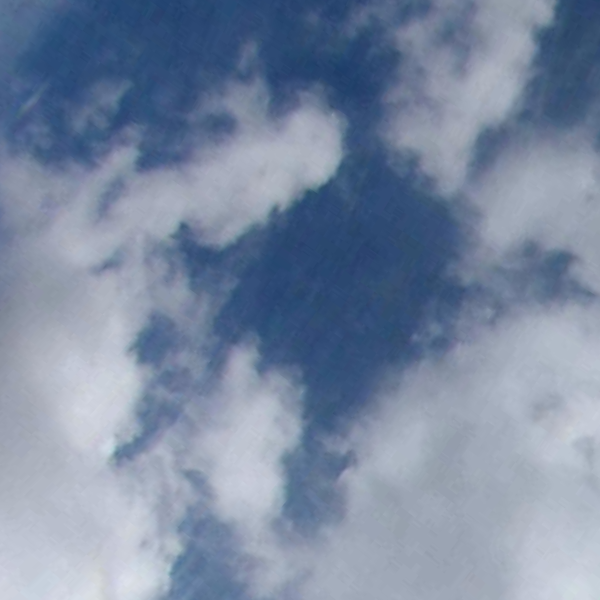

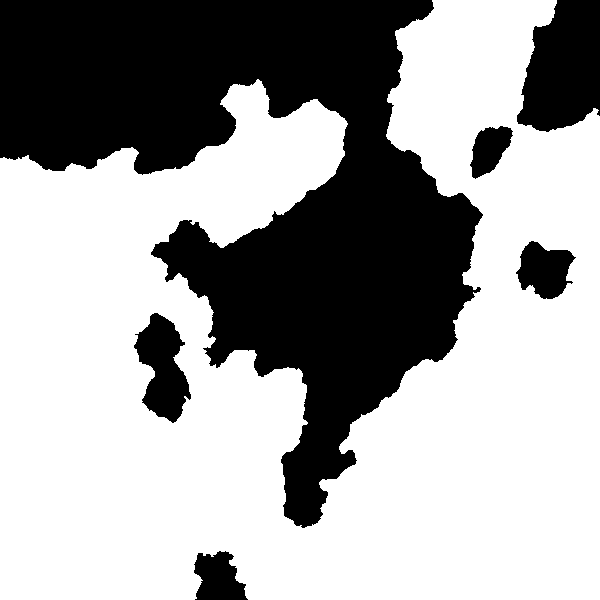

In [16]:
# Display input image
display(Image(filename=input_img_paths[1]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[1]))
display(img)

In [17]:
class CloudsClass(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [18]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 592, 592, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 296, 296, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 296, 296, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 296, 296, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
# Split our img paths into a training and a validation set
val_samples = 203
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples] 
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = CloudsClass(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = CloudsClass(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [20]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("sky_segment.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/5
810/810 [==============================] - 1425s 2s/step - loss: 383.6748 - val_loss: 352.8387
Epoch 2/5
810/810 [==============================] - 1427s 2s/step - loss: 354.9018 - val_loss: 352.7724
Epoch 3/5
810/810 [==============================] - 1422s 2s/step - loss: 353.6003 - val_loss: 352.7590
Epoch 4/5
810/810 [==============================] - 1416s 2s/step - loss: 353.3879 - val_loss: 352.8824
Epoch 5/5
810/810 [==============================] - 1412s 2s/step - loss: 353.0981 - val_loss: 352.8143


In [25]:
# Generate predictions for all images in the validation set

val_gen = CloudsClass(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [169]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmin(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    blurred = median_filter(mask, size = 25)
    #img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = keras.preprocessing.image.array_to_img(blurred)
    
    return(img)

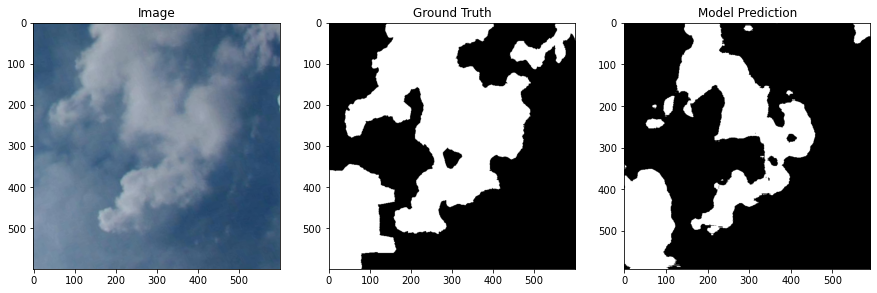

In [184]:
i = 101

fig, axs = plt.subplots(1,3, figsize=(15, 30))
fig.patch.set_facecolor('white')

axs[0].imshow(load_img(val_input_img_paths[i]))
axs[0].set_title('Image')

axs[1].imshow(load_img(val_target_img_paths[i]))
axs[1].set_title('Ground Truth')

axs[2].imshow(display_mask(i), cmap='gray');
axs[2].set_title('Model Prediction');

In [175]:
model.save('sky_segmentation.hdf5')

In [178]:
reconstructed_model = keras.models.load_model('sky_segmentation.hdf5')

In [185]:
#reconstructed_model.get_weights()